In [1]:
import glob
import math
import os
import time

from pathlib import Path
from IPython import display

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import tensorflow_docs.vis.embed as embed

from tensorflow.keras import layers

plt.rcParams["figure.figsize"] = (12, 8)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-02-13 16:18:38.419318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 16:18:38.419340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ROOT_PATH = Path().resolve().parent

DATA_PATH = ROOT_PATH.joinpath("data")
CHECKPOINT_PATH = ROOT_PATH.joinpath("gan_checkpoints")

MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")

In [3]:
train_df = pd.read_csv(MNIST_TRAIN)
train_df = train_df.drop(columns=["label"])

x_train = train_df.values.astype(np.float32)

For the training we've decided to normalize the data to range [-1, 1] and use overall 50 epochs with batch size of 64.<br>
For the testing we are generating a set of 16 images (in a 4x4 grid) where the initial image generated is a random noise.

In [4]:
# Normalizing data to [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = (x_train - 127.5) / 127.5


In [5]:
epochs = 50
batch_size = 64
no_generated = 16

assert math.sqrt(no_generated) == int(math.sqrt(no_generated)), "Ciupaga, the number of generated images must be a perfect square!"

noise_dim = 88
seed = tf.random.normal([no_generated, noise_dim])

2022-02-13 16:18:41.147401: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-13 16:18:41.147427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fedora-desktop
2022-02-13 16:18:41.147433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fedora-desktop
2022-02-13 16:18:41.147480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-13 16:18:41.147498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-13 16:18:41.147503: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-13 16:18:41.147822: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU inst

In [6]:
# Defining the dataset for the generator
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=len(x_train)).batch(batch_size)

For the generator model we've decided to use the dense layer as the input followed by three transposed convolutional layers which work as upsampling layers. The upsampling layers are used to generate an image corresponding to the size of original iamges.

Each layer is followed by a batch normalization layer and a leaky ReLU activation function except the last layer which is followed by a tanh activation function.

In [31]:
generator = tf.keras.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

generator.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1103872   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 128)       

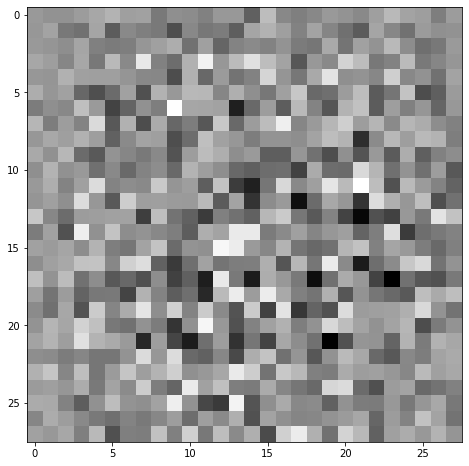

In [32]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

For the discriminator model we've used a rather simple architecture consisting of three convolutional layers followed by a fully connected layer with only one output. The output is a binary value which is 1 if the image is real and 0 if the image is fake.

Each convolutinal layer is followed by a batch normalization layer and a leaky ReLU activation function with increasing size of units for each subsequent layer.

In [33]:
discriminator = tf.keras.Sequential()

discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

discriminator.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [34]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00270339]], shape=(1, 1), dtype=float32)


In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [38]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

manager = tf.train.CheckpointManager(checkpoint, str(CHECKPOINT_PATH), max_to_keep=5)


We had to create a custom training function including training step because we had to train two models simultaneously.

In [39]:
@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


In [40]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    size = int(math.sqrt(no_generated))
    _ = plt.figure(figsize=(size, size))

    for i in range(predictions.shape[0]):
        plt.subplot(size, size, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("../images/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()


In [41]:
gen_losses = []
disc_losses = []

def train(dataset, epochs, batch_size):
    checkpoint.restore(manager.latest_checkpoint)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1} / {epochs}")
        start = time.time()

        for ind, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            if ind == len(dataset) - 1:
                print(f"Generator loss: {gen_loss}")
                print(f"Discriminator loss: {disc_loss}")

                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)

        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=str(CHECKPOINT_PATH / "ckpt"))

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec.")

    generate_and_save_images(generator, epochs, seed)



Epoch 1 / 50
Generator loss: 0.9801747798919678
Discriminator loss: 1.2711175680160522


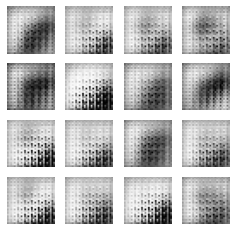

Time for epoch 1 is 49.56498408317566 sec.

Epoch 2 / 50
Generator loss: 0.7679767608642578
Discriminator loss: 1.1084949970245361


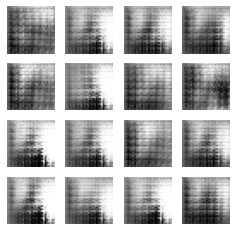

Time for epoch 2 is 45.69022083282471 sec.

Epoch 3 / 50
Generator loss: 0.6454471945762634
Discriminator loss: 1.219577431678772


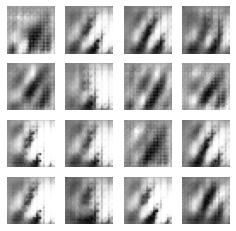

Time for epoch 3 is 45.79086709022522 sec.

Epoch 4 / 50
Generator loss: 0.7590670585632324
Discriminator loss: 1.311133623123169


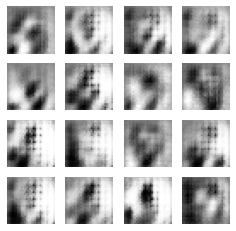

Time for epoch 4 is 44.89687466621399 sec.

Epoch 5 / 50
Generator loss: 0.7248589396476746
Discriminator loss: 1.431850552558899


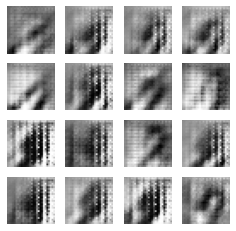

Time for epoch 5 is 44.373414754867554 sec.

Epoch 6 / 50
Generator loss: 0.5206396579742432
Discriminator loss: 1.7124985456466675


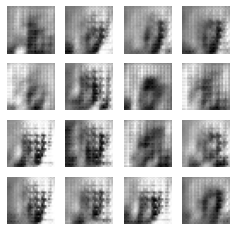

Time for epoch 6 is 44.301570415496826 sec.

Epoch 7 / 50
Generator loss: 0.8710072040557861
Discriminator loss: 1.4208824634552002


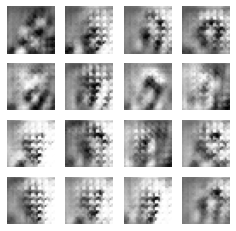

Time for epoch 7 is 42.671046018600464 sec.

Epoch 8 / 50
Generator loss: 0.8004218935966492
Discriminator loss: 1.3136861324310303


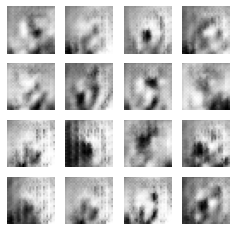

Time for epoch 8 is 42.316558837890625 sec.

Epoch 9 / 50
Generator loss: 0.6484893560409546
Discriminator loss: 1.4359723329544067


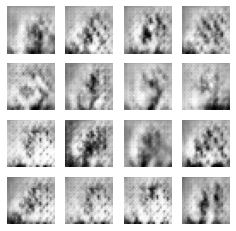

Time for epoch 9 is 42.30759596824646 sec.

Epoch 10 / 50
Generator loss: 0.8869649171829224
Discriminator loss: 1.2632917165756226


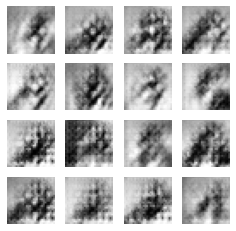

Time for epoch 10 is 42.7148871421814 sec.

Epoch 11 / 50
Generator loss: 0.8638197183609009
Discriminator loss: 1.055842638015747


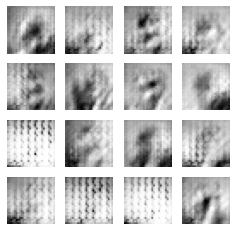

Time for epoch 11 is 43.885985374450684 sec.

Epoch 12 / 50
Generator loss: 1.0095845460891724
Discriminator loss: 1.1365900039672852


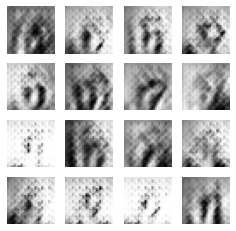

Time for epoch 12 is 42.78630781173706 sec.

Epoch 13 / 50
Generator loss: 0.8105594515800476
Discriminator loss: 1.357588291168213


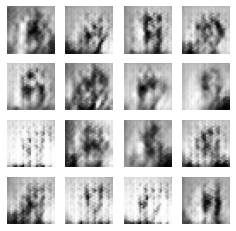

Time for epoch 13 is 42.41993975639343 sec.

Epoch 14 / 50
Generator loss: 0.947872519493103
Discriminator loss: 0.9707149267196655


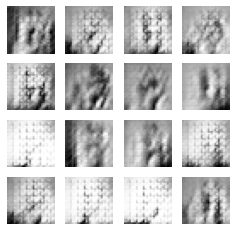

Time for epoch 14 is 43.91237473487854 sec.

Epoch 15 / 50
Generator loss: 1.0990822315216064
Discriminator loss: 1.050162434577942


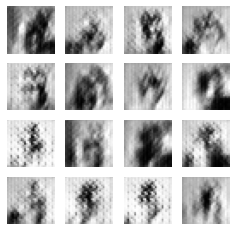

Time for epoch 15 is 45.17150092124939 sec.

Epoch 16 / 50
Generator loss: 0.8685228824615479
Discriminator loss: 1.1360034942626953


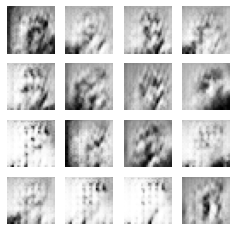

Time for epoch 16 is 45.865724325180054 sec.

Epoch 17 / 50
Generator loss: 0.9336127042770386
Discriminator loss: 1.1466834545135498


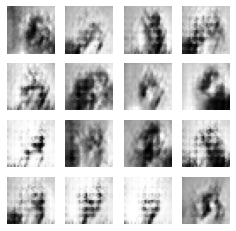

Time for epoch 17 is 45.16645288467407 sec.

Epoch 18 / 50
Generator loss: 1.0190702676773071
Discriminator loss: 0.9201667904853821


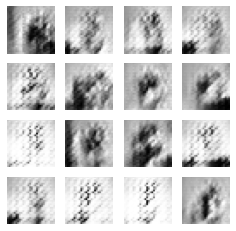

Time for epoch 18 is 44.394418239593506 sec.

Epoch 19 / 50
Generator loss: 1.2550673484802246
Discriminator loss: 0.9200395345687866


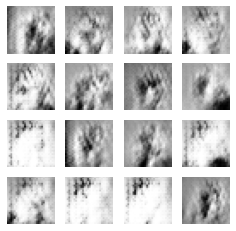

Time for epoch 19 is 43.17764401435852 sec.

Epoch 20 / 50
Generator loss: 0.90908282995224
Discriminator loss: 1.1241707801818848


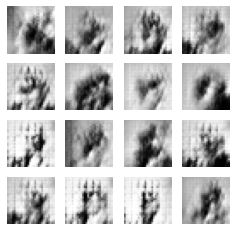

Time for epoch 20 is 45.74250888824463 sec.

Epoch 21 / 50
Generator loss: 1.0913715362548828
Discriminator loss: 0.912695050239563


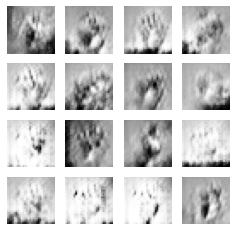

Time for epoch 21 is 46.77908182144165 sec.

Epoch 22 / 50
Generator loss: 1.0184224843978882
Discriminator loss: 1.0259418487548828


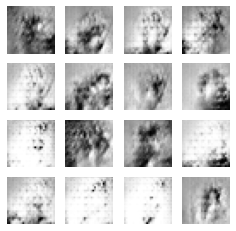

Time for epoch 22 is 45.86855340003967 sec.

Epoch 23 / 50
Generator loss: 1.0066089630126953
Discriminator loss: 1.196791172027588


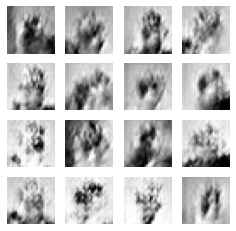

Time for epoch 23 is 48.49350023269653 sec.

Epoch 24 / 50
Generator loss: 1.1514482498168945
Discriminator loss: 1.144315242767334


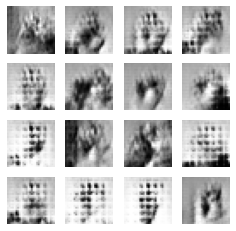

Time for epoch 24 is 49.00725531578064 sec.

Epoch 25 / 50
Generator loss: 0.8624039888381958
Discriminator loss: 1.2437504529953003


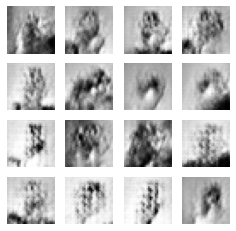

Time for epoch 25 is 46.2174768447876 sec.

Epoch 26 / 50
Generator loss: 1.1899995803833008
Discriminator loss: 1.0106881856918335


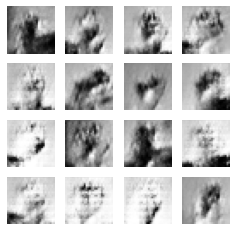

Time for epoch 26 is 52.771045207977295 sec.

Epoch 27 / 50
Generator loss: 1.5202534198760986
Discriminator loss: 0.8609766960144043


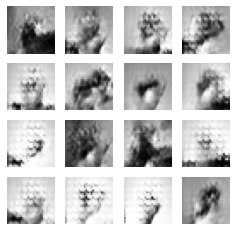

Time for epoch 27 is 50.38329863548279 sec.

Epoch 28 / 50
Generator loss: 1.2792021036148071
Discriminator loss: 1.0404818058013916


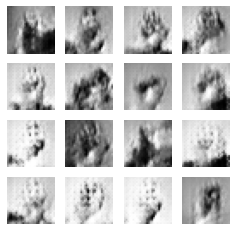

Time for epoch 28 is 51.408841133117676 sec.

Epoch 29 / 50
Generator loss: 1.1722828149795532
Discriminator loss: 0.9399228096008301


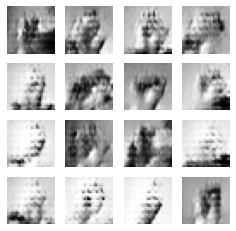

Time for epoch 29 is 48.97335958480835 sec.

Epoch 30 / 50
Generator loss: 1.071454405784607
Discriminator loss: 1.1344636678695679


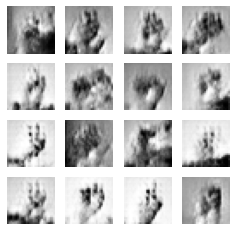

Time for epoch 30 is 44.91003704071045 sec.

Epoch 31 / 50
Generator loss: 0.9923722743988037
Discriminator loss: 1.1641573905944824


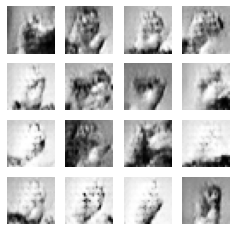

Time for epoch 31 is 46.1375675201416 sec.

Epoch 32 / 50
Generator loss: 1.2814557552337646
Discriminator loss: 0.972594141960144


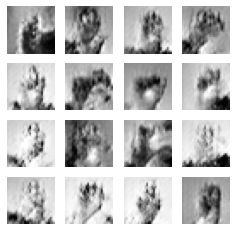

Time for epoch 32 is 46.44879674911499 sec.

Epoch 33 / 50
Generator loss: 1.023730754852295
Discriminator loss: 1.0218254327774048


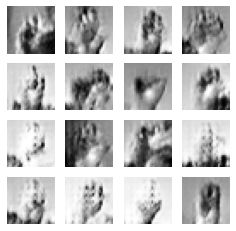

Time for epoch 33 is 52.468568563461304 sec.

Epoch 34 / 50
Generator loss: 1.3513803482055664
Discriminator loss: 1.0566997528076172


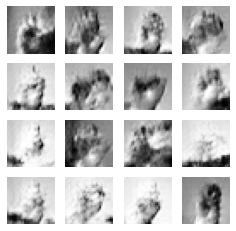

Time for epoch 34 is 45.63112926483154 sec.

Epoch 35 / 50
Generator loss: 1.4582109451293945
Discriminator loss: 0.8697965741157532


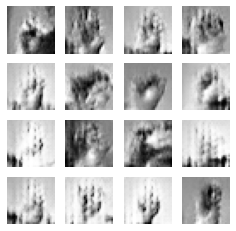

Time for epoch 35 is 48.39960551261902 sec.

Epoch 36 / 50
Generator loss: 1.1656208038330078
Discriminator loss: 1.066144585609436


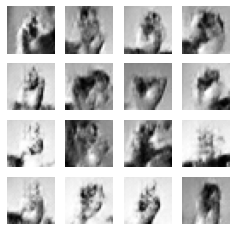

Time for epoch 36 is 49.817113161087036 sec.

Epoch 37 / 50
Generator loss: 1.0804250240325928
Discriminator loss: 1.1001818180084229


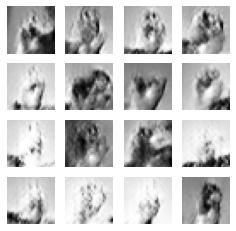

Time for epoch 37 is 45.18377089500427 sec.

Epoch 38 / 50
Generator loss: 1.3387932777404785
Discriminator loss: 1.0803606510162354


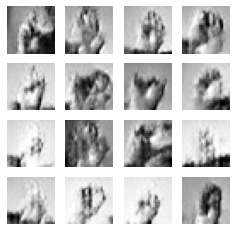

Time for epoch 38 is 45.0992157459259 sec.

Epoch 39 / 50
Generator loss: 1.4723364114761353
Discriminator loss: 0.8731012344360352


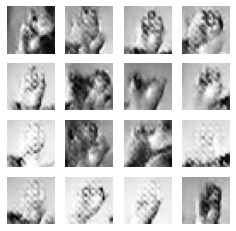

Time for epoch 39 is 47.597408294677734 sec.

Epoch 40 / 50
Generator loss: 1.3849883079528809
Discriminator loss: 0.9501585960388184


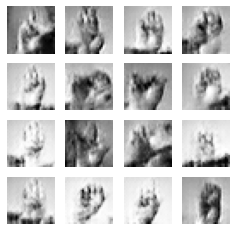

Time for epoch 40 is 45.67292642593384 sec.

Epoch 41 / 50
Generator loss: 1.129592776298523
Discriminator loss: 0.8887902498245239


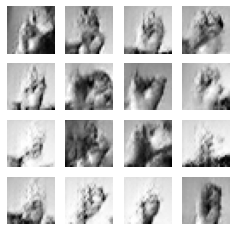

Time for epoch 41 is 48.83390140533447 sec.

Epoch 42 / 50
Generator loss: 1.2731705904006958
Discriminator loss: 1.0728743076324463


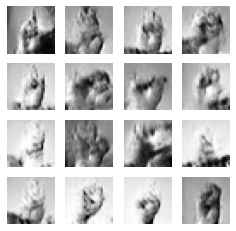

Time for epoch 42 is 46.2384614944458 sec.

Epoch 43 / 50
Generator loss: 1.193627953529358
Discriminator loss: 1.08254075050354


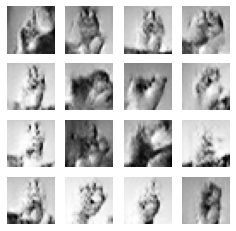

Time for epoch 43 is 46.35946035385132 sec.

Epoch 44 / 50
Generator loss: 1.15433669090271
Discriminator loss: 0.9823130369186401


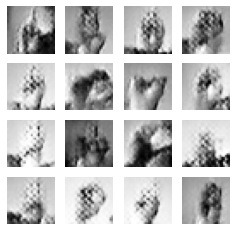

Time for epoch 44 is 46.571866512298584 sec.

Epoch 45 / 50
Generator loss: 1.2335691452026367
Discriminator loss: 1.0147660970687866


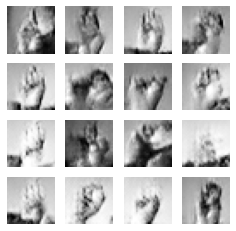

Time for epoch 45 is 48.51109981536865 sec.

Epoch 46 / 50
Generator loss: 0.8941814303398132
Discriminator loss: 1.2457518577575684


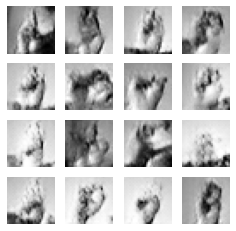

Time for epoch 46 is 45.486117124557495 sec.

Epoch 47 / 50
Generator loss: 1.150748372077942
Discriminator loss: 1.1025824546813965


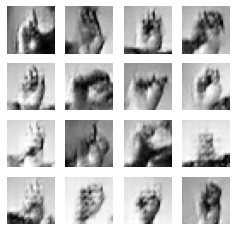

Time for epoch 47 is 47.50496578216553 sec.

Epoch 48 / 50
Generator loss: 1.160057544708252
Discriminator loss: 1.1268787384033203


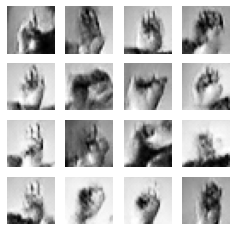

Time for epoch 48 is 46.3870005607605 sec.

Epoch 49 / 50
Generator loss: 1.1638604402542114
Discriminator loss: 1.1191588640213013


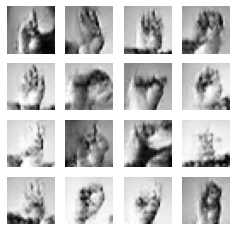

Time for epoch 49 is 49.486708879470825 sec.

Epoch 50 / 50
Generator loss: 0.9852389693260193
Discriminator loss: 1.298788070678711


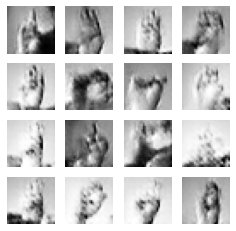

Time for epoch 50 is 48.48070812225342 sec.


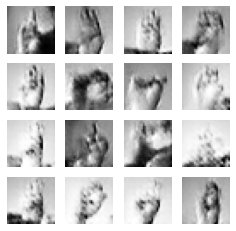

In [42]:
train(dataset, epochs, batch_size)

In [44]:
anim_file = '../images/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('../images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


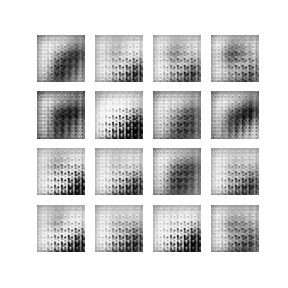

In [45]:
embed.embed_file(anim_file)

The training progress can be seen on the gif above. The gif consists of set of 16 images after each training epoch. With the each epoch we can see that images start to look more realistic although it's far from being a perfect reconstruction. It is also worth mentioning that the training data was not perfect as it was downsampled to the size of 28x28.